# Eval Mode Flag

In [ ]:
eval_mode = True  # Change to False to allow training

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader , Dataset, Subset
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Resize
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report ,roc_curve, auc
from sklearn.manifold import TSNE
import pandas as pd

# Hyper-parameters

In [ ]:
learning_rate = 0.0013143775609750189
weight_decay_val = 1e-4
batch_size = 64
alpha_val = 0.8174896894310268
beta_val = 0.056906205693132296
recon_multiplier = 4.83758931542063
latent_multiplier = 2.857906661057421


# Data Augmentation & Preparation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed * 2)
    random.seed(seed * 3)

set_seeds(42)

# MNIST normalization values
mnist_mean, mnist_std = (0.1307,), (0.3081,)

train_transforms = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(degrees=10),
    transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 1)),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
])

test_transforms = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mnist_mean, mnist_std)
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size, shuffle=False)



# change if you want a different ood:

ood_selector = True  # True for CIFAR10, False for FashionMNIST


if ood_selector:
  ood_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
else:
  ood_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)


Using device: cuda
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.97MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170M/170M [00:05<00:00, 30.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# Base Model

In [ ]:
class MultiClassAutoencoder(nn.Module):
    def __init__(self, num_classes=10):
        super(MultiClassAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # (1,28,28)->(32,28,28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (32,28,28)->(64,14,14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (64,14,14)->(128,7,7)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0),# (128,7,7)->(256,3,3)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),# (256,3,3)->(512,3,3)
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1, output_padding=0), # (512,3,3)->(256,3,3)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0, output_padding=0), # (256,3,3)->(128,7,7)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (128,7,7)->(64,14,14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # (64,14,14)->(32,28,28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),  # (32,28,28)->(1,28,28)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*3*3, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        latent = self.encoder(x)
        decoded = self.decoder(latent)
        logits = self.classifier(latent)
        return logits



# Training & Ploting Functions

### Contrastive loss

In [ ]:
def contrastive_loss(features, labels, margin=1.0):
    """
    Compute a simple contrastive loss on a batch of features.

    Args:
        features: Tensor of shape [batch, latent_dim]
        labels: Tensor of shape [batch]
        margin: The margin for negative pairs.

    Returns:
        A scalar contrastive loss.
    """
    current_batch_size = features.size(0)
    # Compute pairwise distances between all features
    dist_matrix = torch.cdist(features, features, p=2)

    # Create a label matrix: 1 if same class, 0 otherwise
    label_matrix = (labels.unsqueeze(1) == labels.unsqueeze(0)).float()

    # For positive pairs (same class), we want the squared distance to be small.
    pos_loss = label_matrix * (dist_matrix ** 2)
    # For negative pairs, if distance is less than margin, penalize.
    neg_loss = (1 - label_matrix) * F.relu(margin - dist_matrix) ** 2

    # Sum losses and average over number of pairs (excluding self-pairs)
    loss = pos_loss + neg_loss
    # Create a mask to exclude diagonal elements (self comparisons)
    mask = 1 - torch.eye(current_batch_size, device=features.device)
    loss = (loss * mask).sum() / (mask.sum() + 1e-8)
    return loss

### Autoencoder training function

In [ ]:
def train_autoEncoder(
    model, device, train_loader, optimizer, epoch, alpha, beta
    ):
    """
    performs a single training epoch

    Parameters:
        model : The PyTorch model that includes:
        device : The device (CPU or GPU) on which computations are performed.
        train_loader : DataLoader providing the training dataset in batches.
        optimizer : The optimizer for updating model parameters.
        epoch : The current epoch number (used for logging).
        alpha : Weight for the reconstruction loss (MSE).
        beta  Weight for the contrastive loss.

    Returns:
        A tuple (avg_loss, avg_acc) where:
        - avg_loss is the average training loss over all batches in this epoch.
        - avg_acc is the classification accuracy (in %) over all batches in this epoch.
    """
    model.train()
    total_loss = 0.0
    total = 0
    correct = 0

    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        #  Encode data to get latent
        latent = model.encoder(data)

        #  Decode to get reconstruction
        decoded = model.decoder(latent)

        #  Get classification logits
        logits = model.classifier(latent)

        #  Compute losses
        loss_recon = mse_loss(decoded, data)  # Reconstruction loss
        loss_class = ce_loss(logits, target)  # Classification loss
        latent_flat = latent.view(latent.size(0), -1)
        loss_contrast = contrastive_loss(latent_flat, target, margin=1.0)  # Contrastive loss

        # Total loss
        loss = alpha * loss_recon + loss_class + beta * loss_contrast
        loss.backward()
        optimizer.step()

        # Stats
        total_loss += loss.item()
        _, pred = logits.max(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

    avg_loss = total_loss / len(train_loader)
    avg_acc = 100 * correct / total

    return avg_loss, avg_acc  # Return for tracking

### Autoencoder validation function

In [ ]:
def evaluate_autoencoder(model, val_loader, device, mse_loss, ce_loss, alpha, beta):
    """Evaluate model on validation set."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            latent = model.encoder(data)
            decoded = model.decoder(latent)
            logits = model.classifier(latent)

            # Compute losses
            loss_recon = mse_loss(decoded, data)
            loss_class = ce_loss(logits, target)
            latent_flat = latent.view(latent.size(0), -1)
            loss_contrast = contrastive_loss(latent_flat, target, margin=1.0)

            loss = alpha * loss_recon + loss_class + beta * loss_contrast
            total_loss += loss.item()

            # Compute accuracy
            _, pred = logits.max(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    avg_loss = total_loss / len(val_loader)
    avg_acc = 100 * correct / total
    return avg_loss, avg_acc


### Plot training results function

In [ ]:
def plot_training_results(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation loss and accuracy."""
    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", marker="o")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="o", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Training Accuracy", marker="o")
    plt.plot(epochs, val_accs, label="Validation Accuracy", marker="o", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.show()

# Train MultiAE

Base Line model weights saved.


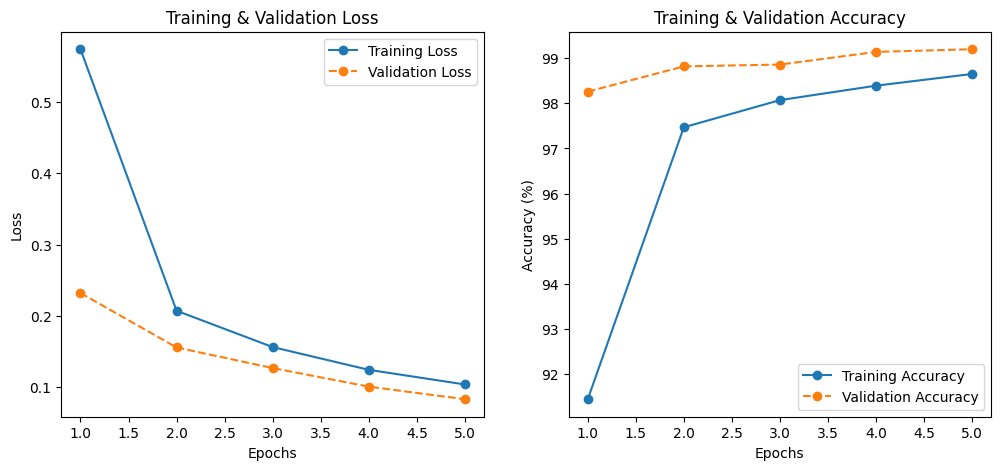

In [ ]:
# Initialize the multi-class autoencoder model and optimizer.

model = MultiClassAutoencoder(num_classes=10).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

# Define loss functions
mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()


num_epochs = 5

if not eval_mode:

  # Store training & validation metrics
  train_losses, val_losses = [], []
  train_accs, val_accs = [], []

  for epoch in range(1, num_epochs + 1):
    # Train and collect loss/accuracy
    train_loss, train_acc = train_autoEncoder( model, device, train_loader, optimizer, epoch, alpha=alpha_val, beta=beta_val )

    # Compute validation loss & accuracy
    val_loss, val_acc = evaluate_autoencoder( model, test_loader, device, mse_loss, ce_loss, alpha=alpha_val, beta=beta_val )

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

  torch.save(model.state_dict(), 'baseline_model.pth')
  print("Base Line model weights saved.")
  plot_training_results(train_losses, val_losses, train_accs, val_accs)
else:
  model.load_state_dict(torch.load('baseline_model.pth', weights_only=True))
  print("Base Line model weights loaded.")



# EVAL MODEL

## Functions For Eval

### Threshold computation function

In [ ]:
def compute_thresholds(model, train_loader, device, recon_multiplier, latent_multiplier):
    """
    Computes reconstruction and cluster-based thresholds for a given model using
    a training dataset.
    """
    model.eval()
    recon_errors = []
    latents = []
    labels = []
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            latent = model.encoder(data)
            decoded = model.decoder(latent)
            logits = model.classifier(latent)
            # Reconstruction error per sample (MSE)
            error = ((decoded - data)**2).mean(dim=[1,2,3])
            recon_errors.append(error.cpu())
            latents.append(latent.view(latent.size(0), -1).cpu())
            labels.append(target.cpu())
    recon_errors = torch.cat(recon_errors)
    latent_all = torch.cat(latents, dim=0)
    labels = torch.cat(labels, dim=0)

    # Global reconstruction threshold:
    recon_threshold = recon_errors.mean() + recon_multiplier * recon_errors.std()

    # Compute per-class centroids using latent features
    n_classes = 10
    latent_dim = latent_all.size(1)
    centroids = torch.zeros(n_classes, latent_dim)
    for i in range(n_classes):
        mask = (labels == i)
        if mask.sum() > 0:
            centroids[i] = latent_all[mask].mean(dim=0)

    # Compute per-cluster thresholds:
    cluster_thresholds = torch.zeros(n_classes)
    dists = torch.cdist(latent_all, centroids)
    for i in range(n_classes):
        mask = (labels == i)
        if mask.sum() > 0:
            # For samples in cluster i, get distance to centroid i.
            cluster_dists = dists[mask][:, i]
            cluster_thresholds[i] = cluster_dists.mean() + latent_multiplier * cluster_dists.std()
        else:
            cluster_thresholds[i] = 0.0
    return recon_threshold, centroids, cluster_thresholds

### OOD Wrapper model

In [ ]:
class OODWrapperMultiClassAE(nn.Module):
    def __init__(self, autoencoder, recon_threshold, cluster_thresholds, centroids):
        """
        autoencoder: Trained MultiClassAutoencoder.
        recon_threshold: Threshold for reconstruction error.
        cluster_thresholds: Tensor of shape [num_classes] with per-cluster latent thresholds.
        centroids: Tensor of shape [num_classes, latent_dim].
        """
        super(OODWrapperMultiClassAE, self).__init__()
        self.autoencoder = autoencoder
        self.recon_threshold = recon_threshold
        # Register per-cluster thresholds and centroids as buffers.
        self.register_buffer("cluster_thresholds", cluster_thresholds)
        self.register_buffer("centroids", centroids)

    def forward(self, x):
        # Instead of relying on autoencoder(x) to return multiple values,
        # we manually obtain the latent representation, reconstruction, and logits.
        latent = self.autoencoder.encoder(x)
        decoded = self.autoencoder.decoder(latent)
        logits = self.autoencoder.classifier(latent)

        # Compute reconstruction error per sample (mean squared error)
        recon_error = ((decoded - x)**2).mean(dim=[1, 2, 3])

        # Flatten latent representation to [B, latent_dim]
        latent_flat = latent.view(latent.size(0), -1)

        # Compute Euclidean distances from latent representations to centroids
        dists = torch.cdist(latent_flat, self.centroids)
        # For each sample, get the minimum distance and its corresponding cluster index
        min_dists, min_idx = dists.min(dim=1)
        # Retrieve per-sample thresholds from cluster_thresholds
        sample_thresholds = self.cluster_thresholds[min_idx]

        # Flag sample as OOD if either:
        # (a) Its reconstruction error exceeds the reconstruction threshold, or
        # (b) Its minimal latent distance exceeds its cluster-specific threshold.
        ood_mask = (recon_error > self.recon_threshold) | (min_dists > sample_thresholds)

        # Create an extra logit for OOD: initialize with a very low value, then set to a high value for flagged samples.
        ood_logits = torch.full((x.size(0), 1), -1e6, device=x.device)
        ood_logits[ood_mask] = 1e6

        # Concatenate the original 10-class logits with the extra OOD logit → 11-class output
        combined_logits = torch.cat((logits, ood_logits), dim=1)
        return combined_logits

### Evaluation Functions

In [ ]:
def evaluate_binary_classification(model, data_loader, device,oodDatasetName):
    """Evaluate the binary classification (Known vs Unknown) accuracy and confusion matrix."""
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            # Model predictions
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            # Map MNIST classes to 0 (Known) and OOD to 1 (Unknown)
            binary_labels = (labels >= 10).long()  # Known: 0, Unknown: 1
            binary_predictions = (predicted >= 10).long()

            y_true.extend(binary_labels.cpu().numpy())
            y_pred.extend(binary_predictions.cpu().numpy())

    # Compute binary classification accuracy
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    accuracy = accuracy*100
    print(f"Binary Classification Accuracy (Known vs Unknown): {accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Known", "Unknown"], yticklabels=["Known", "Unknown"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Binary Classification Confusion Matrix ({oodDatasetName} OOD)")
    plt.show()


def evaluate_osr_results(model, data_loader, device,OOD_flag,oodDatasetName):
    """Evaluate the total accuracy for 10 or 11-class classification and plot the confusion matrix."""
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            # Model predictions
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute total accuracy
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    accuracy = accuracy*100
    print(f"Total Accuracy : {accuracy:.2f}%")
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    if OOD_flag:
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(10)) + ["Unknown"], yticklabels=list(range(10)) + ["Unknown"])
      plt.xlabel("Predicted")
      plt.ylabel("True")
      plt.title(f"11-Class Confusion Matrix ({oodDatasetName} OOD)")
      plt.show()
    else:
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(10)), yticklabels=list(range(10)))
      plt.xlabel("Predicted")
      plt.ylabel("True")
      plt.title(f"10-Class Confusion Matrix ({oodDatasetName})")
      plt.show()


def visualize_tsne_ood(ood_detector, data_loader, device,oodDatasetName):
    """Visualize embeddings using t-SNE with classes based on predictions from the OODDetector and borders for Unknown."""
    ood_detector.eval()
    embeddings = []
    predictions = []

    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)

            # Extract embeddings using the encoder
            latent = ood_detector.autoencoder.encoder(data)
            # Flatten the latent representation to [B, 4608]
            latent_flat = latent.view(latent.size(0), -1)
            embeddings.append(latent_flat.cpu().numpy())

            # Get predictions from the OODDetector
            outputs = ood_detector(data)
            _, predicted = outputs.max(1)  # get predicted class (index of max logit)
            predictions.extend(predicted.cpu().numpy())

    embeddings = np.vstack(embeddings)

    # Apply t-SNE to reduce the embedding dimension to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Prepare a DataFrame for visualization
    df = pd.DataFrame({
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],
        "prediction": predictions  # predicted class labels from the OODDetector
    })

    plt.figure(figsize=(12, 8))

    # Separate 'Unknown' (label 10) and MNIST predictions
    unknown_data = df[df['prediction'] == 10]
    mnist_data = df[df['prediction'] != 10]

    # Plot MNIST points (labels 0–9)
    sns.scatterplot(
        data=mnist_data,
        x="x",
        y="y",
        hue="prediction",
        palette="tab20",
        legend="full",
        alpha=0.7,
    )

    # Plot Unknown points (label 10) with black borders
    plt.scatter(
        unknown_data["x"],
        unknown_data["y"],
        facecolor=sns.color_palette("tab20")[10 % 20],
        edgecolor="black",
        linewidth=0.5,
        alpha=0.7,
        label="Unknown (Label 10)"
    )

    # Manually update the legend to include all 11 labels (0–9 + "Unknown")
    handles, labels = plt.gca().get_legend_handles_labels()
    full_labels = [str(i) for i in range(10)] + ["Unknown"]
    full_handles = handles[:10] + [handles[-1]]
    plt.legend(full_handles, full_labels, title="Predicted Labels", loc="best")

    plt.title(f"t-SNE Visualization ({oodDatasetName} OOD)")
    plt.show()

### Functions from project_utils.py

In [ ]:
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10



def eval_model(model, data_loader, device):
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            ### Modify output if needed ###
            #data = data.view(-1, 28*28)
            # Model outputs
            outputs = model(data)

            # y pred should be a vector of size (N_batch,) -> [5, 2, ..., 10]
            # and not one-hot. You can handle this either in your model or here.
            #  # probas, y_pred = evaluate_model_ODIN_no_loader(model, data, labels, device)
            # Assuming the model returns an (N_batch, 11) size output
            probas, y_pred = torch.max(outputs, 1)
            #print(f"probas{probas}")
            #print(f"y_pred{y_pred}")

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            # Note: Not one-hot!
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total


## Compute Thresholds & Initiate Wrapper Model

In [ ]:
if eval_mode:
  # Compute thresholds using the training data
  recon_threshold, centroids, cluster_thresholds = compute_thresholds(model , train_loader , device , recon_multiplier , latent_multiplier )

  # Wrap the trained autoencoder with OOD detection capabilities.
  ood_model = OODWrapperMultiClassAE(model, recon_threshold, cluster_thresholds, centroids).to(device)

## Evaluation - CIFAR10/FashionMNIST








### BaseLine Results - AutoEncoder on MNIST

Base Model (multi-Autoencoder) on MNIST dataset:

Total Accuracy : 99.20%


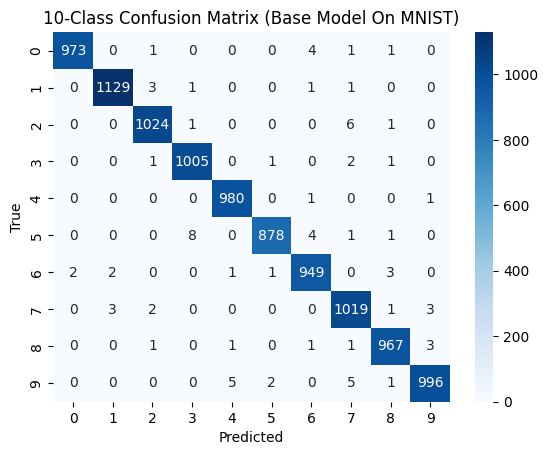

In [ ]:
if eval_mode:
  print("Base Model (multi-Autoencoder) on MNIST dataset:\n")
  evaluate_osr_results(model, test_loader, device, False,"Base Model On MNIST")

### Combine Dataset For CIFAR10/FashionMNIST

In [ ]:
combined_dataset = CombinedDataset(test_dataset, ood_dataset ,transform_mnist=None, transform_ood=test_transforms)
combined_loader = DataLoader(combined_dataset , batch_size , shuffle=True)

oodName = "CIFAR10" if ood_selector  else "FashionMNIST"

### Our OSR Approach:
Our final approach for this project is out-of-distribution (OOD) detection based on reconstruction error and distance from latent feature clustering.

To achieve this, we implemented a wrapper class that follows a two-step verification process:


*   It first checks whether the reconstruction error exceeds a predefined threshold.
*   If the error is within the acceptable range, it then verifies whether the latent feature distance meets the clustering distance thresholds.
   
  
Any sample that does not satisfy these conditions is considered OOD, samples that do satisfy the conditions are passed to classification.
Our OOD-detection wrapper class makes use of the multi-Autoencoder model to extract the relevent information and to classify relevnt samples.

### OOD Results

OOD Results:

Binary Classification Accuracy (Known vs Unknown): 99.04%


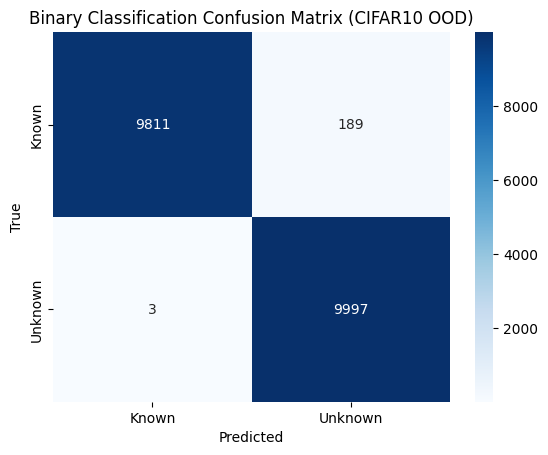

In [ ]:
if eval_mode:
  print("OOD Results:\n")
  evaluate_binary_classification(ood_model, combined_loader, device,oodName)

### OSR Results

OSR Results:

MNIST Accuracy: 97.69%
OOD Accuracy: 99.97%
Total Accuracy : 98.83%


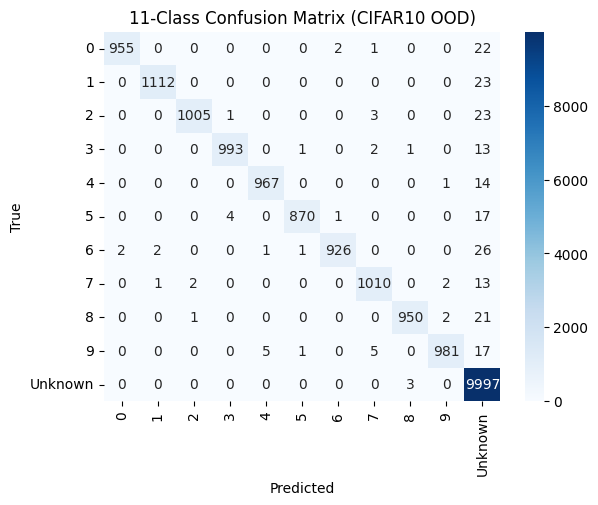

In [ ]:
if eval_mode:
  print("OSR Results:\n")

  acc_mnist, acc_ood,_ = eval_model(ood_model, combined_loader, device)

  print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
  print(f'OOD Accuracy: {acc_ood*100:.2f}%')


  evaluate_osr_results(ood_model, combined_loader, device, True,oodName)

### TSNE

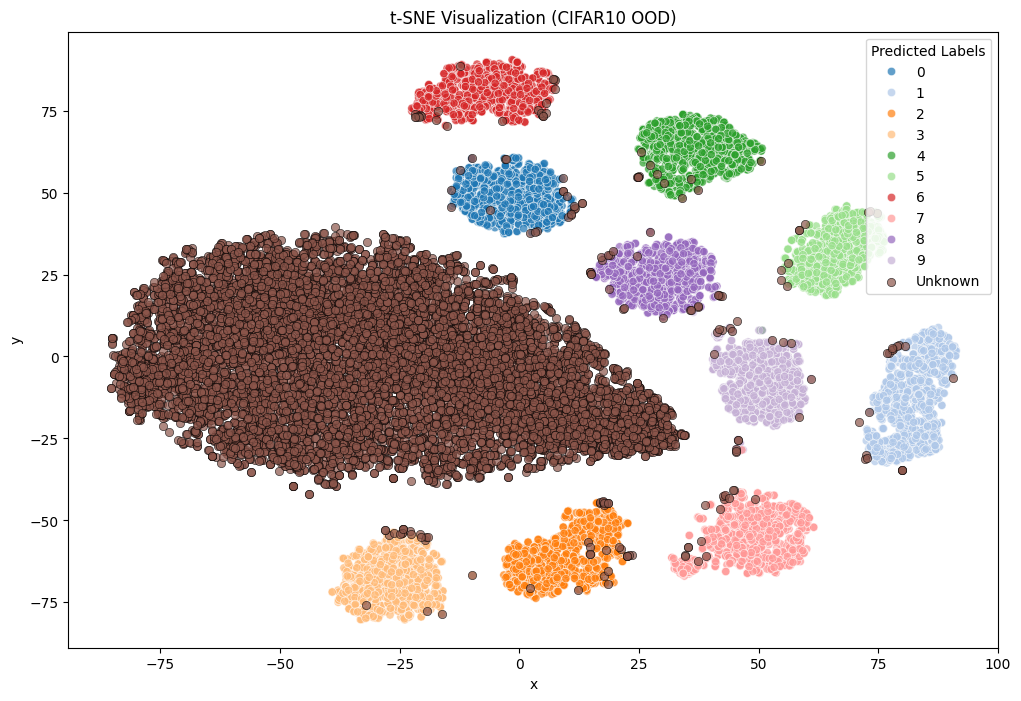

In [ ]:
if eval_mode:
  visualize_tsne_ood(ood_model, combined_loader, device,oodName)